In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
df = pd.read_csv("../data/test.csv", encoding='cp949')
df.head()

,거래일자,거래시간,지역_energy,태양광 발전량(MWh),풍력 발전량(MWh),거래년도,일시
0,2020-01-01,1,경기도,0.04,0.17,2020,2020/01/01 1:00
1,2020-01-01,2,경기도,0.01,0.31,2020,2020/01/01 2:00
2,2020-01-01,3,경기도,0.00,0.18,2020,2020/01/01 3:00
3,2020-01-01,4,경기도,0.00,0.09,2020,2020/01/01 4:00
4,2020-01-01,5,경기도,0.00,0.10,2020,2020/01/01 5:00


In [3]:
# '풍력 발전량'과 '일시' 열만 선택
wind_df = df[[' 풍력 발전량(MWh) ', '일시']]

wind_df.head()

,풍력 발전량(MWh),일시
0,0.17,2020/01/01 1:00
1,0.31,2020/01/01 2:00
2,0.18,2020/01/01 3:00
3,0.09,2020/01/01 4:00
4,0.10,2020/01/01 5:00


In [4]:
# '일시' 열을 날짜 형식으로 변환
df['일시'] = pd.to_datetime(df['일시'], format='%Y/%m/%d %H:%M')

# '일시'를 기준으로 그룹화하고 '태양광 발전량'을 합산
wind_df_day = df.groupby(df['일시'].dt.date)[' 풍력 발전량(MWh) '].sum().reset_index()

wind_df_day.tail()

,일시,풍력 발전량(MWh)
1091,2022-12-27,8926.67
1092,2022-12-28,19072.22
1093,2022-12-29,15698.58
1094,2022-12-30,12732.63
1095,2022-12-31,19228.00


## 시계열 분석

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA

In [6]:
# '일시' 열을 인덱스로 설정
wind_df_day.set_index('일시', inplace=True)

ts = wind_df_day
ts.head()

일시
2020-01-01    15246.09
2020-01-02    11980.39
2020-01-03    13333.55
2020-01-04    11819.13
2020-01-05     2075.51
Name:  풍력 발전량(MWh) , dtype: float64

In [7]:
ts.tail()

일시
2022-12-27     8926.67
2022-12-28    19072.22
2022-12-29    15698.58
2022-12-30    12732.63
2022-12-31    19228.00
Name:  풍력 발전량(MWh) , dtype: float64

In [8]:
# 결측치 확인

ts.isnull().sum()

0

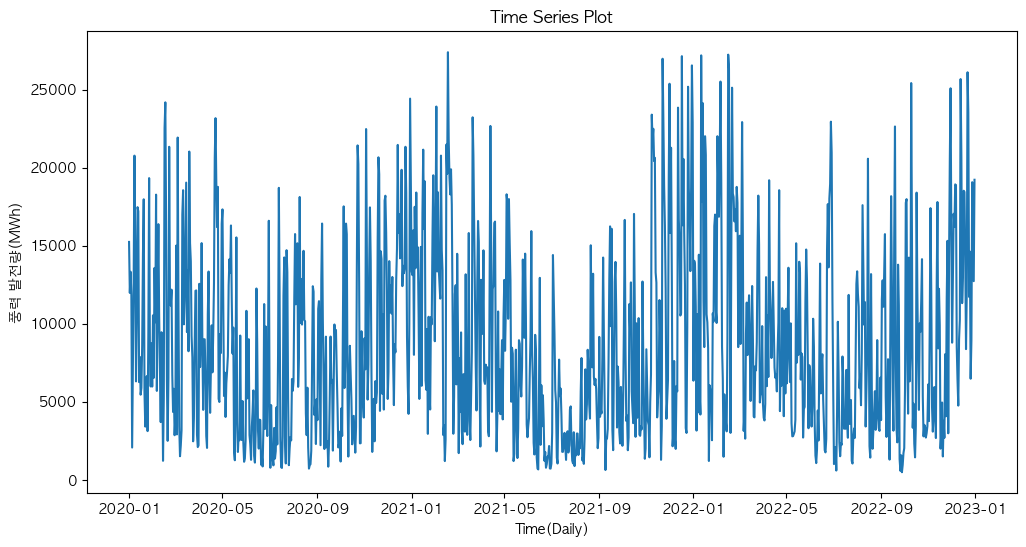

In [10]:
# 시계열 데이터 시각화

plt.figure(figsize=(12, 6))
plt.plot(ts)
plt.title('Time Series Plot')
plt.xlabel('Time(Daily)')
plt.ylabel('풍력 발전량(MWh)')
plt.show()

In [11]:
# plt 확장

from pylab import rcParams
rcParams['figure.figsize']=15,10

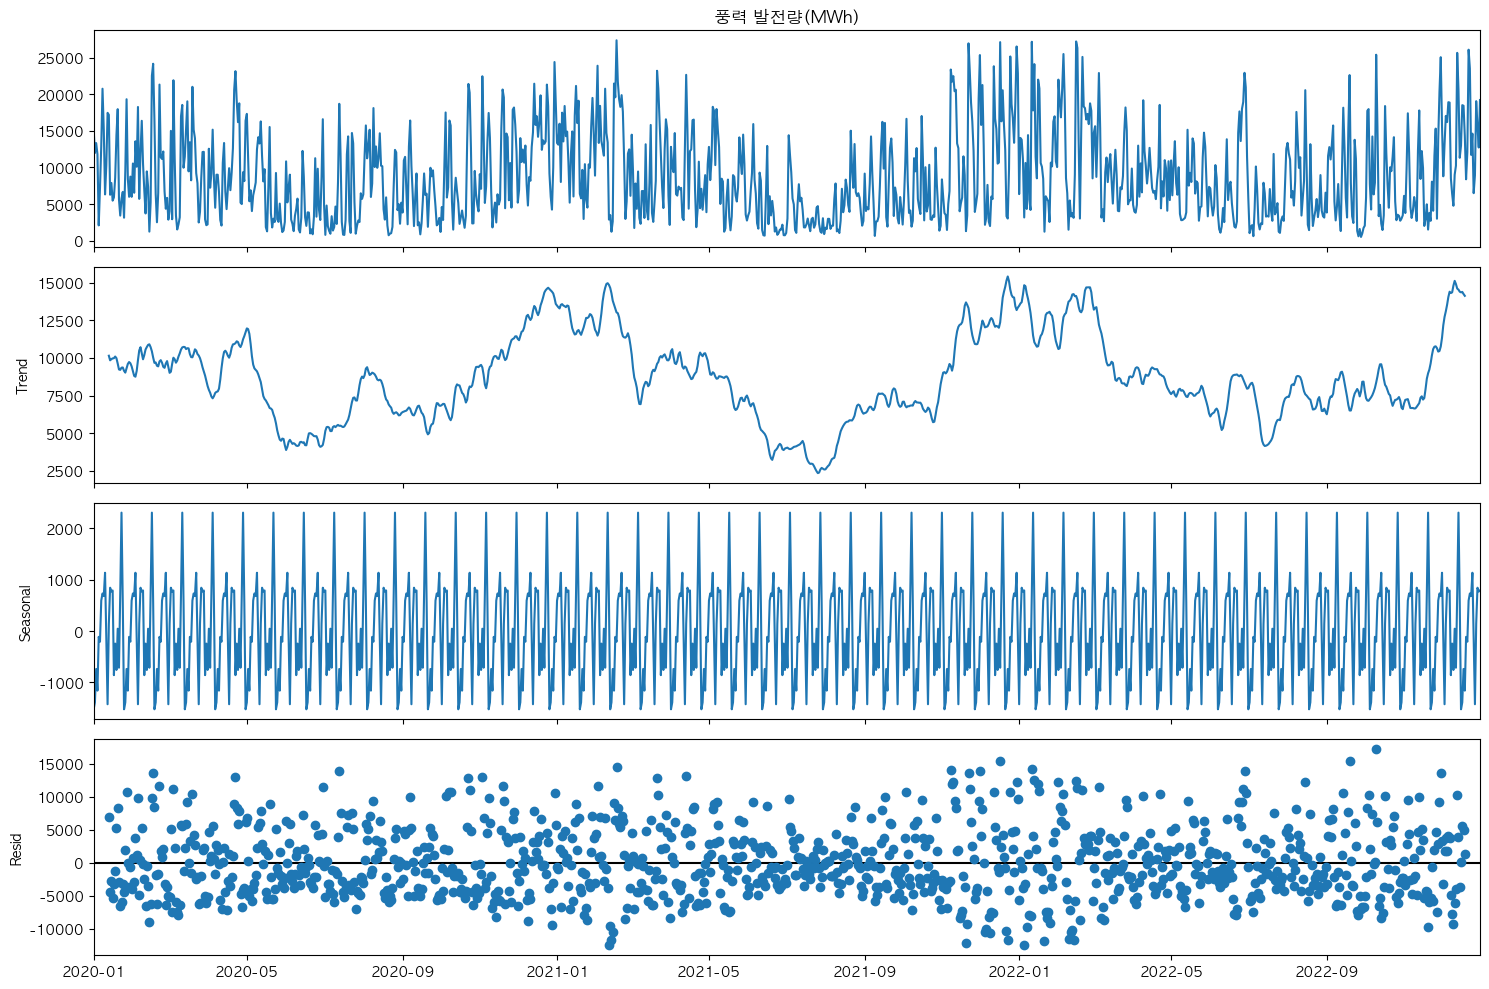

In [12]:
# 시계열 분해

result = seasonal_decompose(ts, model='additive', period=24)
result.plot()
plt.show()

## 정상성 검정

In [13]:
# 1. KPSS 검정

kpss_test_result = kpss(ts)

print(f'KPSS Statistic: {kpss_test_result[0]}')
print(f'p-value: {kpss_test_result[1]}')
print(f'Lags Used: {kpss_test_result[2]}')
print(f'Critical Values: {kpss_test_result[3]}')

print(f'검증결과: {"비정상(non-stationary)" if kpss_test_result[1] <= 0.05 else "정상(stationary)"} 시계열 데이터입니다.')

KPSS Statistic: 0.15591509243174848
p-value: 0.1
Lags Used: 14
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
검증결과: 정상(stationary) 시계열 데이터입니다.


/var/folders/pl/c1z33rhx0tz096sc8p4_flzw0000gn/T/ipykernel_14463/2197487823.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test_result = kpss(ts)


In [14]:
# 2. ADF 검정

adf_test_result = adfuller(ts, autolag='AIC')

print(f'ADF Statistic: {adf_test_result[0]}')
print(f'p-value: {adf_test_result[1]}')
print(f'Critical Values: {adf_test_result[4]}')
print(f'Best number of lags (AIC): {adf_test_result[3]}')

# 검증 결과 출력
print(f'검증결과: {"정상(stationary)" if adf_test_result[1] <= 0.05 else "비정상(non-stationary)"} 시계열 데이터입니다.')

ADF Statistic: -4.065860472999209
p-value: 0.0011023148814966494
Critical Values: {'1%': -3.436425000208065, '5%': -2.864222352544219, '10%': -2.5681981773275466}
Best number of lags (AIC): 1079
검증결과: 정상(stationary) 시계열 데이터입니다.


- 기존 풍력 시계열 데이터가 정상 시계열 데이터

## AutoRegressive Integrated Moving Average(ARIMA) 모델

In [19]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [20]:
# 데이터를 학습 데이터와 검증 데이터로 나누기
train_size = int(len(ts) * 0.8)
train, validation = ts[0:train_size], ts[train_size:]

# 가능한 매개변수 조합 생성
p_values = range(0, 2)
d_values = range(0, 2)
q_values = range(0, 2)

# 최적 매개변수 초기화
best_aic, best_cfg = float("inf"), None

# Grid Search를 통한 최적 매개변수 찾기
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                # ARIMA 모델 생성 및 훈련
                model = ARIMA(train, order=order)
                fit_model = model.fit()

                # AIC 계산
                aic = fit_model.aic

                # 현재 조합의 성능이 더 좋으면 갱신
                if aic < best_aic:
                    best_aic, best_cfg = aic, order

            except Exception as e:
                print(f"An exception occurred during model training: {str(e)}")
                continue

# 최적 매개변수 출력
print(f"Best ARIMA Order (by AIC): {best_cfg}")
print(f"Best AIC: {best_aic}")

# 최적 매개변수로 ARIMA 모델 훈련 및 예측
best_model = ARIMA(ts, order=best_cfg)
best_fit_model = best_model.fit()

# 예측
predictions = best_fit_model.predict(start=len(train), end=len(ts) - 1, dynamic=False)

# 예측 결과와 실제 데이터 비교
# MSE, RMSE 계산
mse = mean_squared_error(validation, predictions)
rmse = np.sqrt(mse)

print(f'Mean Squared Error on Validation Data: {mse}')
print(f'Root Mean Squared Error on Validation Data: {rmse}')

# MAPE 계산
mape = mean_absolute_percentage_error(validation, predictions)

print(f'Mean Absolute Percentage Error on Validation Data: {mape:.4f}')

Best ARIMA Order (by AIC): (1, 0, 1)
Best AIC: 17405.603062277896
Mean Squared Error on Validation Data: 23637708.764572266
Root Mean Squared Error on Validation Data: 4861.862684668528
Mean Absolute Percentage Error on Validation Data: 0.8908


/Users/choiseoyeo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/choiseoyeo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/choiseoyeo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/choiseoyeo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/choiseoyeo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency i